# exploration 11번째 과제
@ 황한용(3기/쏘카)

## 라이브러리 선언

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
from numpy.random import randn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Conv2DTranspose
                                     , Dense, Dropout, Flatten, LeakyReLU, Reshape)
from IPython import display
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6 
import matplotlib.pyplot as plt
%matplotlib inline

## 상수선언

In [2]:
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/data/gen"
SAMPLE_PATH = BASE_PATH + "/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png"
TRAIN_PATH = BASE_PATH + "/training_history/train_history_{:04d}.png"
CHECKPOINT_PREFIX_PATH = BASE_PATH + "/training_checkpoints"
GIF_PATH = BASE_PATH + "/dcgan_v1.gif"
BATCH_SIZE = 256 # rgb_len
V2_LR = 0.0002
TRAIN_SAVE_EVERY = 5
NOISE_DIM = 100 # random sample image dim
GEN_SAMPLE_NUM = 16
CROSS_ENTROPY = keras.losses.BinaryCrossentropy(from_logits=True)
V1_OPTIMIZER_KWARG = dict(learning_rate=1e-4)
V2_OPTIMIZER_KWARG = dict(learning_rate=V2_LR, beta_1=0.5)

## 함수

In [3]:
def make_generator_model_v1():
	""" 기존의 모델 """
	# Start
	model = keras.Sequential(name="v1_gen_model")

    # First: Dense layer
	model.add(Dense(8*8*256, use_bias=False, input_shape=(NOISE_DIM,)))
	model.add(BatchNormalization())
	model.add(LeakyReLU())

	# Second: Reshape layer
	model.add(Reshape((8, 8, 256)))

	# Third: Conv2DTranspose layer
	model.add(Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
	model.add(BatchNormalization())
	model.add(LeakyReLU())

	# Fourth: Conv2DTranspose layer
	model.add(Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
	model.add(BatchNormalization())
	model.add(LeakyReLU())

	# Fifth: Conv2DTranspose layer
	model.add(Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
	                                 activation='tanh'))

	return model

def make_discriminator_model_v1():
	""" 기존의 판별자 모델 """
	# Start
	model = tf.keras.Sequential(name="v1_disc_model")

	# First: Conv2D Layer
	model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
	model.add(LeakyReLU())
	model.add(Dropout(0.3))

	# Second: Conv2D Layer
	model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU())
	model.add(Dropout(0.3))

	# Third: Flatten Layer
	model.add(Flatten())

	# Fourth: Dense Layer
	model.add(Dense(1))

	return model

def generator_loss(fake_output):
    return CROSS_ENTROPY(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = CROSS_ENTROPY(tf.ones_like(real_output), real_output)
    fake_loss = CROSS_ENTROPY(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i]+1) /2)
        plt.axis('off')
   
    plt.savefig(SAMPLE_PATH.format(epoch, it))

    plt.show()

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig(TRAIN_PATH.format(os.getenv('HOME'), epoch))
    plt.show()

def train_v1(dataset, seed, checkpoint, save_every, epochs=300):
	generator = make_generator_model_v1()
	discriminator = make_discriminator_model_v1()

	@tf.function
	def train_step(images):  #(1) 입력데이터
		noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])  #(2) 생성자 입력 노이즈

		with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
			generated_images = generator(noise, training=True)  #(4) generated_images 생성

			#(5) discriminator 판별
			real_output = discriminator(images, training=True)
			fake_output = discriminator(generated_images, training=True)

			#(6) loss 계산
			gen_loss = generator_loss(fake_output)
			disc_loss = discriminator_loss(real_output, fake_output)

			#(7) accuracy 계산
			real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
		
		#(8) gradient 계산
		gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
		gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

		#(9) 모델 학습
		Adam(**V1_OPTIMIZER_KWARG).apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
		Adam(**V1_OPTIMIZER_KWARG).apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

		return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값


	start = time.time()
	history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

	for epoch in range(epochs):
		epoch_start = time.time()
		for it, image_batch in enumerate(dataset):
			gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
			history['gen_loss'].append(gen_loss)
			history['disc_loss'].append(disc_loss)
			history['real_accuracy'].append(real_accuracy)
			history['fake_accuracy'].append(fake_accuracy)

			if it % 50 == 0:
				display.clear_output(wait=True)
				generate_and_save_images(generator, epoch+1, it+1, seed)
				print('Epoch {} | iter {}'.format(epoch+1, it+1))
				print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

		if (epoch + 1) % save_every == 0:
			checkpoint.save(file_prefix=CHECKPOINT_PREFIX_PATH)

		display.clear_output(wait=True)
		generate_and_save_images(generator, epochs, it, seed)
		print('Time for training : {} sec'.format(int(time.time()-start)))

		draw_train_history(history, epoch)

######################################################### 개선된 모델 #########################################################

def make_generator_model_v2():
	""" 개선된 모델 """
	model = keras.Sequential(name="v2_gen_model")
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_shape=(NOISE_DIM,)))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

def make_discriminator_model_v2(in_shape=(32,32,3)):
	""" 개선된 모델 """
	model = keras.Sequential(name="v2_disc_model")
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer=Adam(**V2_OPTIMIZER_KWARG), metrics=['accuracy'])
	return model

def gan_model_v2(g_model, d_model):
	""" 생성 모델과 판별모델을 하나로 합치는 과정"""
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = keras.Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer=Adam(**V2_OPTIMIZER_KWARG))
	return model

함수의 개선방안은 아래의 링크를 참고하여 제작하였다.<br>
[참고사이트](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)

## 메인

### 사진의 분석

data shape: (50000, 32, 32, 3)


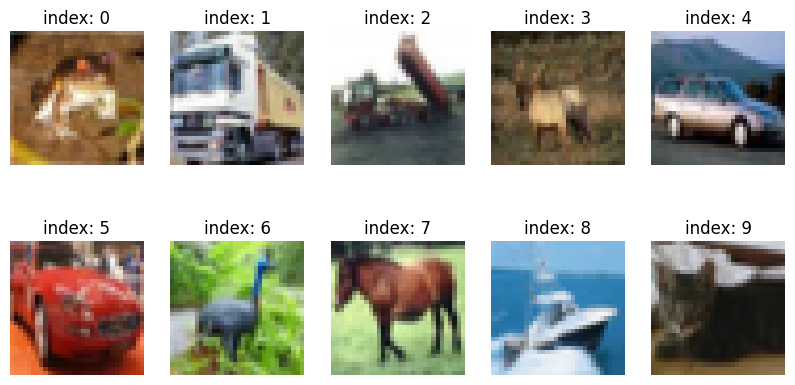

In [4]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

print(f"data shape: {train_x.shape}")

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

데이터는 `keras`에서 기본으로 제공하는 데이터를 사용하였으며<br>
data는 32\*32\*3 칼러 이미지 50,000장<br>
label은 0~9까지의 데이터가 있으며 설명은 아래와 같다.<br>
- 0: T-shirt/top
- 1: Trouser
- 2: Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
- 9: Ankle boot

아래의 그림은 확인용으로 그림 10장정도를 그려보았다. 

### 전처리

In [5]:
train_x = (train_x - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(train_x.shape[0]).batch(BATCH_SIZE)

미리 학습된 segmentation모델을 로드 후<br>
피사체에 피사체에 해당하는 색으로 칠하였다.<br>
고양이 사진의 경우 변수가 없으므로 완벽하게 피사체를 인식하였다.<br>
여성의 피사체를 일부 누락이 있지만 인식하여 알맞는 색을 칠한 것을 볼 수있다.<br>
이미지에 칠한 색은 아래의 목록을 확인하면 알 수 있다.<br>

### 학습설계

In [6]:
generator_v1 = make_generator_model_v1()
generator_v1.summary()

print("\n" + "#"*65 + "\n")

generator_v2 = make_generator_model_v2()
generator_v2.summary()

Model: "v1_gen_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)       

exploration 예제가 `28*28*3` 과제가 `32*32*3`형태의 그림으로 input값이 변경되었으므로 <br>
초기 input을 `7,7,256` -> `8,8,256`으로 변경시켜 준것 밖에 없다.<br>

개선한 모델의 경우에는 `4,4,256`로 input을 조정해 좀더 연산하는 layer를 늘렸다.<br>
또한 음수값일때의 기울기를 조정하여 학습률을 높혔다.<br>

생성결과 각 레이어의 노드가 줄어든 것에 대해 확인이 가능하다.<br>

non trained image shape: (1, 32, 32, 3)


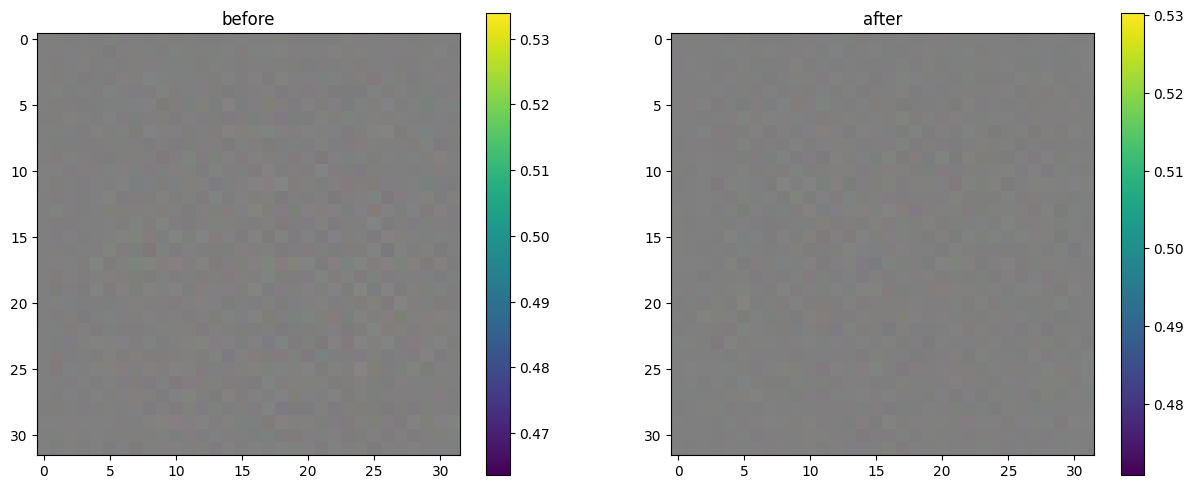

In [7]:
noise_v1 = tf.random.normal([1, 100], 0, 1) # 균일분포를 통한 랜덤값
noise_v2 = randn(100).reshape(1,-1) # 가우시안 정규분포를 통한 랜덤값
generated_image_v1 = generator_v1(noise_v1, training=False)
generated_image_v2 = generator_v1(noise_v2, training=False)

print(f"non trained image shape: {generated_image_v1.shape}")

plt.subplot(1, 2, 1)
plt.imshow((generated_image_v1[0] + 1) / 2)
plt.title(f'before')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow((generated_image_v2[0] + 1) / 2)
plt.title(f'after')
plt.colorbar()
plt.show()

1~100까지의 랜덤의 수를 적용시킨 array를 생성한다.<br>
김종태 그루님의 도움으로 랜덤으로 이미지를 생성할 시<br>
(`random 이미지의 백터` + 1) /2 가 이미지의 화소를<br>
0~1사이로 분표시켜 이미지가 잘 보이게 된다는 조언을 듣고 적용하였다.<br>
생성결과 두 사진의 차이는 크게 보이지 않는다.<br>

In [8]:
discriminator_v1 = make_discriminator_model_v1()
discriminator_v1.summary()

print("\n" + "#"*65 + "\n")

discriminator_v2 = make_discriminator_model_v2()
discriminator_v2.summary()

Model: "v1_disc_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

위의 생성자 모델과 같이 leaky relu의 α값 조정, 레이어 1층 증가 이외 달라진 점이 없다.<br>

In [9]:
decision_v1 = discriminator_v1(generated_image_v1, training=False)
print(decision_v1)

print("\n" + "#"*58 + "\n")

decision_v2 = discriminator_v2(generated_image_v2, training=False)
print(decision_v2)

tf.Tensor([[0.00348925]], shape=(1, 1), dtype=float32)

##########################################################

tf.Tensor([[0.49974605]], shape=(1, 1), dtype=float32)


생성자도 별다른 이상없이 동작이 가능한 것을 볼 수 있다.

In [10]:
checkpoint = tf.train.Checkpoint(generator_optimizer=Adam(**V1_OPTIMIZER_KWARG),
                                 discriminator_optimizer=Adam(**V1_OPTIMIZER_KWARG),
                                 generator=generator_v1,
                                 discriminator=Adam(**V1_OPTIMIZER_KWARG))

train_v1(
    train_dataset
    , tf.random.normal([GEN_SAMPLE_NUM, NOISE_DIM])
    ,checkpoint
    , TRAIN_SAVE_EVERY
    , 1)

ValueError: in user code:

    File "C:\Users\Owner\AppData\Local\Temp\ipykernel_33428\999203045.py", line 130, in train_step  *
        Adam(**V1_OPTIMIZER_KWARG).apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    File "c:\Program Files\Python39\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 646, in apply_gradients  **
        self._create_all_weights(var_list)
    File "c:\Program Files\Python39\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 858, in _create_all_weights
        _ = self.iterations
    File "c:\Program Files\Python39\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 866, in __getattribute__
        return super(OptimizerV2, self).__getattribute__(name)
    File "c:\Program Files\Python39\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 1033, in iterations
        self._iterations = self.add_weight(
    File "c:\Program Files\Python39\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 1233, in add_weight
        variable = self._add_variable_with_custom_getter(
    File "c:\Program Files\Python39\lib\site-packages\keras\engine\base_layer_utils.py", line 126, in make_variable
        return tf.compat.v1.Variable(

    ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.


In [ ]:
with imageio.get_writer(GIF_PATH, mode='I') as writer:
    filenames = glob.glob(BASE_PATH + "/generated_samples/sample*.png")
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

### 회고


- 학습된 데이터의 의존성이 강하다는 것을 알게되었다.
- 사실 이번 과제를 하기위해 `colab`과 로컬에서 환경설정을 하려고 했지만 모두 실패하여 이틀을 날렸다.<br>
환경설정의 중요함을 알았다.